In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Specify the desired input shape for VGG16
input_shape = (224, 224, 3)

# Create an ImageDataGenerator with rescaling and aggressive data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,
    preprocessing_function=lambda x: tf.image.resize(x, (input_shape[0], input_shape[1])),
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    fill_mode='nearest'
)

# Specify the path to your dataset
dataset_path = "C:/Users/user_99/Desktop/data_of_parikar"

# Create data generators for training, validation, and test
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Further split the validation_generator into validation and test generators
validation_split = 0.5
test_split = 0.5

num_validation_samples = int(validation_split * validation_generator.samples)
num_test_samples = int(test_split * validation_generator.samples)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

num_validation_steps = num_validation_samples // 32
num_test_steps = num_test_samples // 32

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional base, unfreeze the last 3 convolutional layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Create a new model with additional dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(13, activation='softmax'))

# Compile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',  # Save the model when validation loss is minimized
    verbose=1      # Add this line for more details on the saving process
)

# Train the model using the data generators and save the history
history = model.fit(train_generator, epochs=100, validation_data=validation_generator,callbacks=[early_stopping, model_checkpoint])

# Save the training and validation loss plots as JPG files
save_dir = "C:/Users/user_99/Desktop/"
save_file_loss = os.path.join(save_dir, "training_validation_loss_plot.jpg")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_file_loss)
plt.show()
plt.close()

# Save the training and validation accuracy plots as JPG files
save_file_accuracy = os.path.join(save_dir, "training_validation_accuracy_plot.jpg")

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_file_accuracy)
plt.show()
plt.close()

# Display the saved file paths
print(f"Training and validation loss plot saved at: {save_file_loss}")
print(f"Training and validation accuracy plot saved at: {save_file_accuracy}")

# Evaluate the model on the validation set
validation_results = model.evaluate(validation_generator, steps=num_validation_steps)
print("Validation Loss:", validation_results[0])
print("Validation Accuracy:", validation_results[1])

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=num_test_steps)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 8581 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Epoch 1/100
269/269 [==============================] - ETA: 0s - loss: 7.2109 - accuracy: 0.2863
Epoch 00001: val_loss improved from inf to 6.34323, saving model to best_model.h5
269/269 [==============================] - 240s 862ms/step - loss: 7.2109 - accuracy: 0.2863 - val_loss: 6.3432 - val_accuracy: 0.4875
Epoch 2/100
269/269 [==============================] - ETA: 0s - loss: 6.1568 - accuracy: 0.5219
Epoch 00002: val_loss improved from 6.34323 to 5.86641, saving model to best_model.h5
269/269 [==============================] - 215s 801ms/step - loss: 6.1568 - accuracy: 0.5219 - val_loss: 5.8664 - val_accuracy: 0.5728
Epoch 3/100
269/269 [==============================] - ETA: 0s - loss: 5.7129 - accuracy: 0.6026
Epoch 00003: val_loss improved from 5.86641 to 5.49881, saving model to best_model.h5
269/269 [====

Found 8581 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Found 5711 images belonging to 13 classes.
Epoch 56/100
269/269 [==============================] - ETA: 0s - loss: 1.1335 - accuracy: 0.9197
Epoch 00056: val_loss improved from inf to 1.40507, saving model to best_model.h5
269/269 [==============================] - 228s 822ms/step - loss: 1.1335 - accuracy: 0.9197 - val_loss: 1.4051 - val_accuracy: 0.8456
Epoch 57/100
269/269 [==============================] - ETA: 0s - loss: 1.0923 - accuracy: 0.9295
Epoch 00057: val_loss improved from 1.40507 to 1.37456, saving model to best_model.h5
269/269 [==============================] - 217s 806ms/step - loss: 1.0923 - accuracy: 0.9295 - val_loss: 1.3746 - val_accuracy: 0.8484
Epoch 58/100
269/269 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.9229
Epoch 00058: val_loss improved from 1.37456 to 1.32375, saving model to best_model.h5
269/269 [=

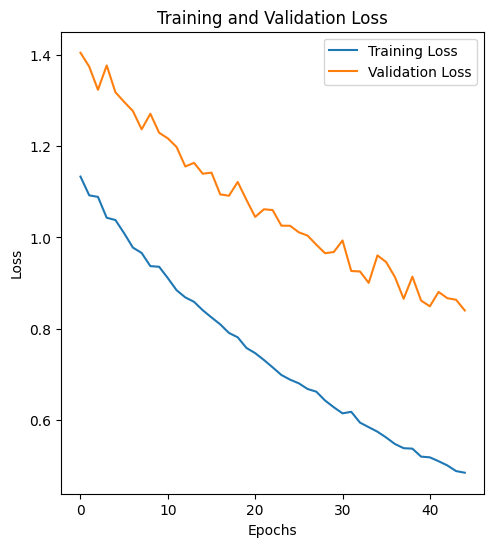

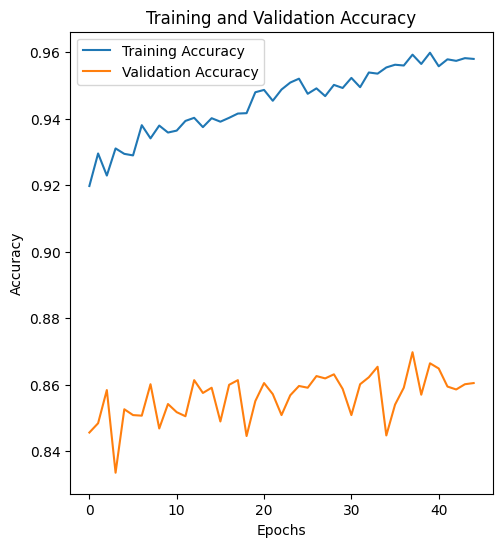

Training and validation loss plot saved at: C:/Users/user_99/Desktop/training_validation_loss_plot.jpg
Training and validation accuracy plot saved at: C:/Users/user_99/Desktop/training_validation_accuracy_plot.jpg
89/89 [==============================] - 43s 480ms/step - loss: 0.7446 - accuracy: 0.8890
Validation Loss: 0.7445828914642334
Validation Accuracy: 0.8890449404716492
89/89 [==============================] - 43s 477ms/step - loss: 0.7498 - accuracy: 0.8894
Test Loss: 0.7497875094413757
Test Accuracy: 0.889396071434021


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Specify the desired input shape for VGG16
input_shape = (224, 224, 3)

# Create an ImageDataGenerator with rescaling and aggressive data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,
    preprocessing_function=lambda x: tf.image.resize(x, (input_shape[0], input_shape[1])),
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    fill_mode='nearest'
)

# Specify the path to your dataset
dataset_path = "C:/Users/user_99/Desktop/data_of_parikar"

# Create data generators for training, validation, and test
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Further split the validation_generator into validation and test generators
validation_split = 0.5
test_split = 0.5

num_validation_samples = int(validation_split * validation_generator.samples)
num_test_samples = int(test_split * validation_generator.samples)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

num_validation_steps = num_validation_samples // 32
num_test_steps = num_test_samples // 32

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional base, unfreeze the last 3 convolutional layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Create a new model with additional dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(13, activation='softmax'))

# Compile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implement early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',  # Save the model when validation loss is minimized
    verbose=1      # Add this line for more details on the saving process
)

# Load the previously saved best model if available
saved_model_path = "best_model.h5"
if os.path.exists(saved_model_path):
    model = load_model(saved_model_path)

# Train the model using the data generators and save the history
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint],
                    initial_epoch=0 if not os.path.exists(saved_model_path) else 55)

# Save the training and validation loss plots as JPG files
save_dir = "C:/Users/user_99/Desktop/"
save_file_loss = os.path.join(save_dir, "training_validation_loss_plot.jpg")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_file_loss)
plt.show()
plt.close()

# Save the training and validation accuracy plots as JPG files
save_file_accuracy = os.path.join(save_dir, "training_validation_accuracy_plot.jpg")

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_file_accuracy)
plt.show()
plt.close()

# Display the saved file paths
print(f"Training and validation loss plot saved at: {save_file_loss}")
print(f"Training and validation accuracy plot saved at: {save_file_accuracy}")

# Evaluate the model on the validation set
validation_results = model.evaluate(validation_generator, steps=num_validation_steps)
print("Validation Loss:", validation_results[0])
print("Validation Accuracy:", validation_results[1])

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=num_test_steps)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

In [2]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


tflite_model_path = "C:/Users/user_99/Desktop/tflite_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model) 

INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmpzxuhl5f4\assets


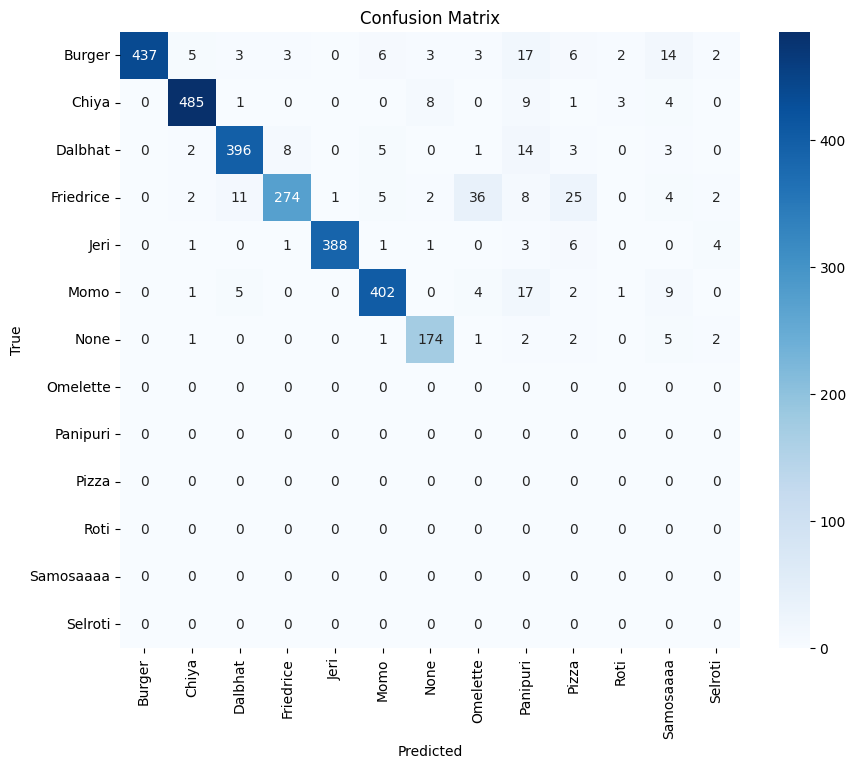

C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Burger       1.00      0.87      0.93       501
       Chiya       0.98      0.95      0.96       511
     Dalbhat       0.95      0.92      0.93       432
   Friedrice       0.96      0.74      0.84       370
        Jeri       1.00      0.96      0.98       405
        Momo       0.96      0.91      0.93       441
        None       0.93      0.93      0.93       188
    Omelette       0.00      0.00      0.00         0
    Panipuri       0.00      0.00      0.00         0
       Pizza       0.00      0.00      0.00         0
        Roti       0.00      0.00      0.00         0
   Samosaaaa       0.00      0.00      0.00         0
     Selroti       0.00      0.00      0.00         0

    accuracy                           0.90      2848
   macro avg       0.52      0.48      0.50      2848
weighted avg       0.97      0.90      0.93      2848



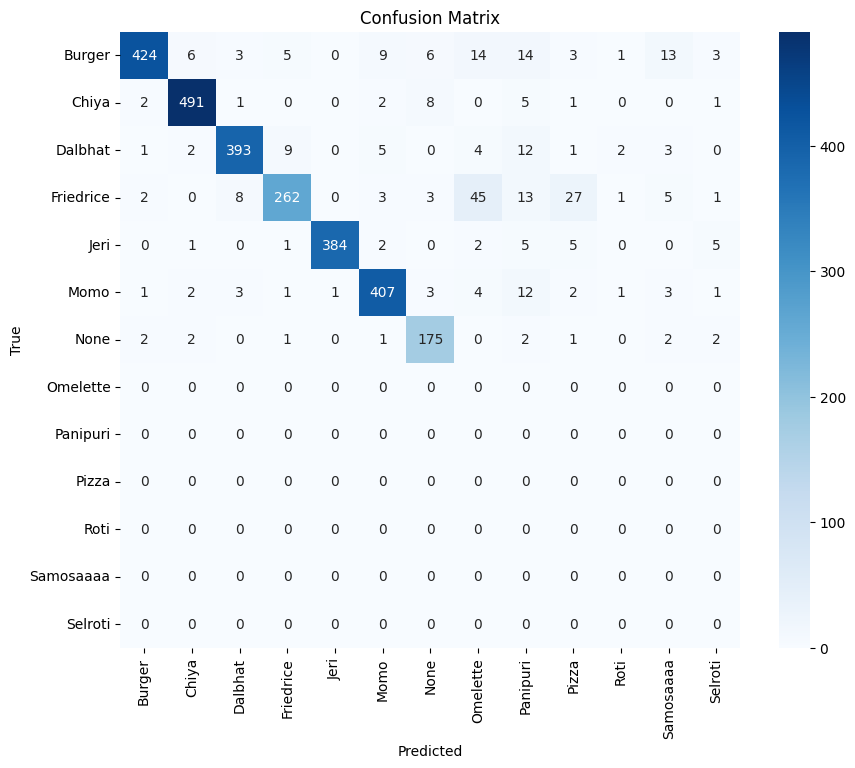

              precision    recall  f1-score   support

      Burger       0.98      0.85      0.91       501
       Chiya       0.97      0.96      0.97       511
     Dalbhat       0.96      0.91      0.94       432
   Friedrice       0.94      0.71      0.81       370
        Jeri       1.00      0.95      0.97       405
        Momo       0.95      0.92      0.94       441
        None       0.90      0.93      0.91       188
    Omelette       0.00      0.00      0.00         0
    Panipuri       0.00      0.00      0.00         0
       Pizza       0.00      0.00      0.00         0
        Roti       0.00      0.00      0.00         0
   Samosaaaa       0.00      0.00      0.00         0
     Selroti       0.00      0.00      0.00         0

    accuracy                           0.89      2848
   macro avg       0.52      0.48      0.50      2848
weighted avg       0.96      0.89      0.92      2848



C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user_99\anaconda3\envs\GPUEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to evaluate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model, data_generator, num_steps, class_labels):
    y_true = []
    y_pred = []

    for i in range(num_steps):
        x_batch, y_batch = data_generator.next()
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
        y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

    plot_confusion_matrix(y_true, y_pred, class_labels)
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Class labels for your problem
class_labels = ['Burger', 'Chiya', 'Dalbhat', 'Friedrice', 'Jeri', 'Momo', 'None', 'Omelette', 'Panipuri', 'Pizza', 'Roti', 'Samosaaaa', 'Selroti']

# Evaluate and plot confusion matrix on the validation set
evaluate_and_plot_confusion_matrix(model, validation_generator, num_validation_steps, class_labels)

# Evaluate and plot confusion matrix on the test set
evaluate_and_plot_confusion_matrix(model, test_generator, num_test_steps, class_labels)

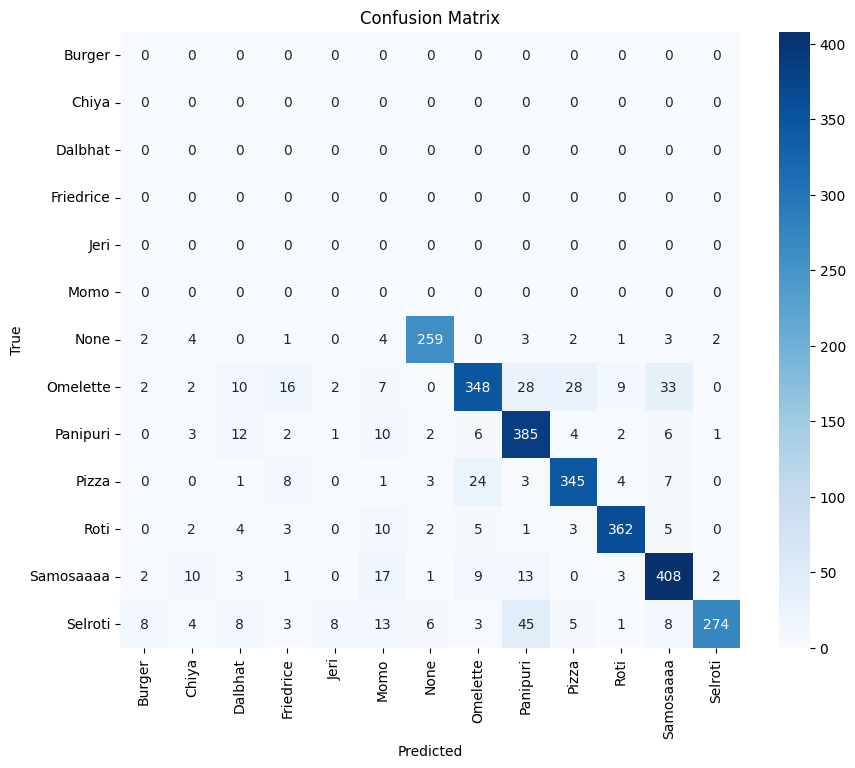

ValueError: Number of classes, 8, does not match size of target_names, 13. Try specifying the labels parameter

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to evaluate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model, data_generator, num_steps, class_labels):
    num_classes = len(class_labels)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(num_steps):
        x_batch, y_batch = data_generator.next()
        y_true = np.argmax(y_batch, axis=1)
        y_pred = np.argmax(model.predict(x_batch), axis=1)

        # Update confusion matrix
        for true, pred in zip(y_true, y_pred):
            conf_matrix[true, pred] += 1

    plot_confusion_matrix(conf_matrix, class_labels)
    print(classification_report(np.argmax(y_batch, axis=1), y_pred, target_names=class_labels))

# Class labels for your problem
class_labels = ['Burger', 'Chiya', 'Dalbhat', 'Friedrice', 'Jeri', 'Momo', 'None', 'Omelette', 'Panipuri', 'Pizza', 'Roti', 'Samosaaaa', 'Selroti']

# Evaluate and plot confusion matrix on the validation set
evaluate_and_plot_confusion_matrix(model, validation_generator, num_validation_steps, class_labels)

# Evaluate and plot confusion matrix on the test set
evaluate_and_plot_confusion_matrix(model, test_generator, num_test_steps, class_labels)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to evaluate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model, data_generator, num_steps, class_labels):
    num_classes = len(class_labels)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(num_steps):
        x_batch, y_batch = data_generator.next()
        y_true = np.argmax(y_batch, axis=1)
        y_pred = np.argmax(model.predict(x_batch), axis=1)

        # Update confusion matrix
        for true, pred in zip(y_true, y_pred):
            conf_matrix[true, pred] += 1

    # Print unique values in y_true and y_pred for debugging
    print("Unique values in y_true:", np.unique(y_true))
    print("Unique values in y_pred:", np.unique(y_pred))

    # Ensure that the number of unique classes matches the size of target_names
    assert len(np.unique(y_true)) == len(np.unique(y_pred)) == num_classes

    plot_confusion_matrix(conf_matrix, class_labels)
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Class labels for your problem
class_labels = ['Burger', 'Chiya', 'Dalbhat', 'Friedrice', 'Jeri', 'Momo', 'None', 'Omelette', 'Panipuri', 'Pizza', 'Roti', 'Samosa', 'Selroti']

# Evaluate and plot confusion matrix on the validation set
evaluate_and_plot_confusion_matrix(model, validation_generator, num_validation_steps, class_labels)

# Evaluate and plot confusion matrix on the test set
evaluate_and_plot_confusion_matrix(model, test_generator, num_test_steps, class_labels)


Unique values in y_true: [12]
Unique values in y_pred: [ 2  3  4  5  6  8  9 11 12]


AssertionError: 

In [11]:
print("Evaluate on test data")
result = model.evaluate(test_set,batch_size=128)
print("test loss, test acc:", result)

Evaluate on test data


NameError: name 'test_set' is not defined

In [12]:
print("Evaluate on test data")
result = model.evaluate(test_generator, steps=num_test_steps)
print("Test Loss:", result[0])
print("Test Accuracy:", result[1])

Evaluate on test data
89/89 [==============================] - 57s 640ms/step - loss: 0.7315 - accuracy: 0.8936
Test Loss: 0.7314918041229248
Test Accuracy: 0.8936095237731934


In [13]:
# Convert the model to TensorFlow Lite with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_path = "C:/Users/user_99/Desktop/tflite_model_vgg16.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmp4ptcl3qs\assets


INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmp4ptcl3qs\assets
